In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import libraries

In [1]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
import json
from torch.optim import lr_scheduler
import time
import os
from PIL import Image
from pathlib import Path


from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import * 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define batch size
bs = 32
# bs = 16

In [4]:
torch.cuda.current_device()

0

In [5]:
torch.cuda.device_count()

1

In [6]:
torch.cuda.get_device_name(0)

'GeForce GTX 1060 with Max-Q Design'

In [7]:
torch.cuda.set_device(0)

# Look at data

In [3]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False, verbose=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [3]:
# Define where to data bunch
path = '/Users/pbata/Documents/pbata files (personal)/Shopee Code League/C02_Product_Detection/SCL_C02_data/'
train_df = pd.read_csv(path+'train.csv').rename(columns={'category':'label'})
train_df.label = ['0' + str(x) if x <10 else str(x) for x in train_df.label]
train_df.loc[:,'name'] = train_df.apply(lambda x: 'train/'+str(x.label)+'/'+str(x.filename), axis = 1)
train_df.drop('filename', axis = 1, inplace = True)
train_df = train_df.set_index('name').reset_index()

In [7]:
# Sample 10% of data
# df = train_df.sample(frac=0.1, random_state=1)

In [5]:
data = ImageDataBunch.from_df(path, train_df, ds_tfms=get_transforms(), size=299, bs=bs, seed = 2020).normalize(imagenet_stats)

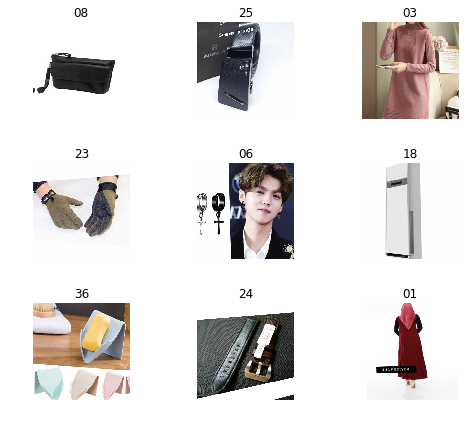

In [10]:
data.show_batch(rows=3, figsize=(7,6))

In [11]:
print(data.classes)
len(data.classes),data.c

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41']


(42, 42)

# Using Inception V3

In [12]:
model = torchvision.models.inception_v3(aux_logits=False)
nf = data.c # number of output classes in your data
model.fc = nn.Linear(in_features=2048, out_features=nf) # replace fc layer

In [13]:
learn = Learner(data, model, metrics = error_rate)

In [14]:
learn.model.cuda()
# inceptionModel = inceptionModel.cuda()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [24]:
learn.fit_one_cycle(4)

In [25]:
learn.save('inceptionv3_1')

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

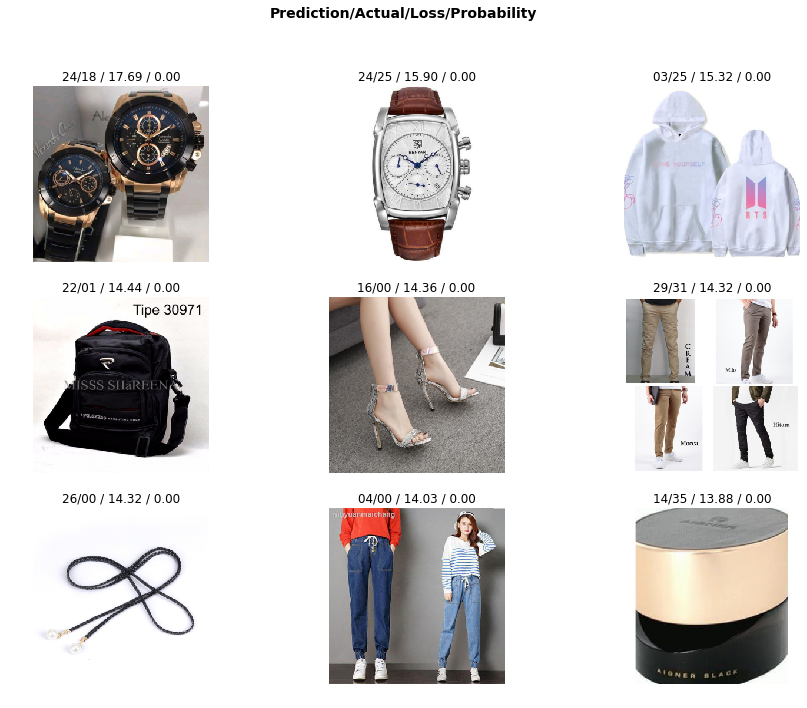

In [27]:
interp.plot_top_losses(9, figsize=(15,11))

In [28]:
doc(interp.plot_top_losses)

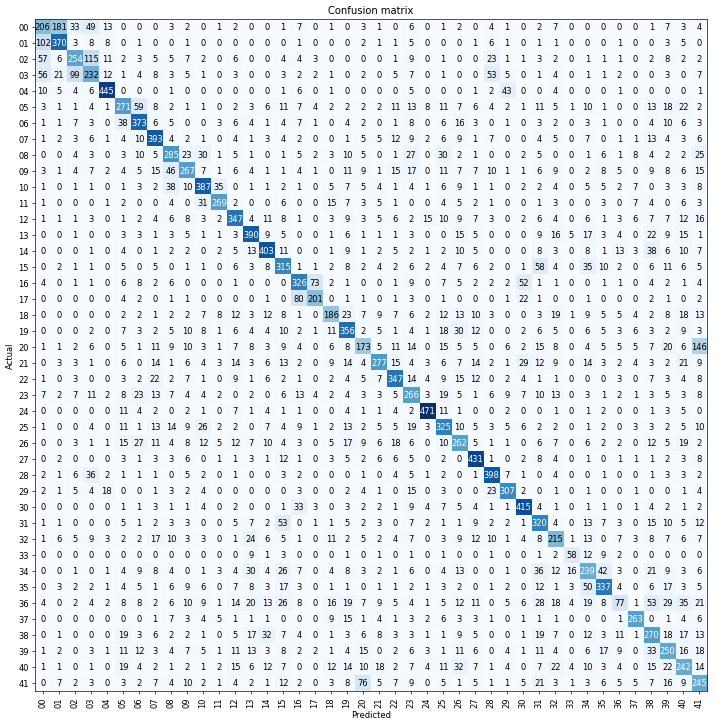

In [29]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [30]:
interp.most_confused(min_val=2)

[('00', '01', 181),
 ('20', '41', 146),
 ('02', '03', 115),
 ('01', '00', 102),
 ('03', '02', 99),
 ('17', '16', 80),
 ('41', '20', 76),
 ('16', '17', 73),
 ('05', '06', 59),
 ('15', '31', 58),
 ('02', '00', 57),
 ('03', '00', 56),
 ('03', '28', 53),
 ('31', '15', 53),
 ('36', '38', 53),
 ('16', '30', 52),
 ('35', '34', 50),
 ('00', '03', 49),
 ('09', '08', 46),
 ('04', '29', 43),
 ('34', '35', 42),
 ('06', '05', 38),
 ('10', '08', 38),
 ('14', '38', 38),
 ('28', '03', 36),
 ('34', '31', 36),
 ('10', '11', 35),
 ('15', '34', 35),
 ('36', '40', 35),
 ('00', '02', 33),
 ('30', '16', 33),
 ('39', '38', 33),
 ('38', '14', 32),
 ('40', '26', 32),
 ('11', '10', 31),
 ('08', '10', 30),
 ('08', '25', 30),
 ('19', '26', 30),
 ('34', '13', 30),
 ('21', '30', 29),
 ('36', '39', 29),
 ('36', '31', 28),
 ('08', '23', 27),
 ('26', '06', 27),
 ('25', '10', 26),
 ('34', '15', 26),
 ('36', '15', 26),
 ('08', '41', 25),
 ('32', '13', 24),
 ('02', '28', 23),
 ('08', '09', 23),
 ('18', '19', 23),
 ('23', 

In [41]:
learn.unfreeze()

In [42]:
learn.fit_one_cycle(1)

In [13]:
learn.load('inceptionv3_1')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
03,03,03,03,03
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
39,05,10,23,15
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Test: None, model=Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


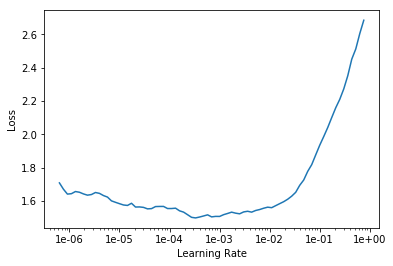

In [15]:
learn.recorder.plot()

In [18]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
   (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (3): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (7): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (9): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (10): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (11): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (12): Conv2d(192

In [21]:
learn.fit_one_cycle(2, max_lr=1e-3)

# Taining with max_lr and more epochs

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


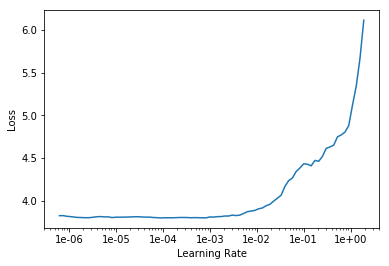

In [17]:
learn.recorder.plot()

In [18]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
   (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (3): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (7): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (9): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (10): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (11): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (12): Conv2d(192

In [20]:
learn.fit_one_cycle(10)

In [21]:
learn.save('inceptionv3_2')

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [27]:
learn.load('inceptionv3_2')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
03,03,03,03,03
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
39,05,10,23,15
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Test: None, model=Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 120.00 MiB (GPU 0; 6.00 GiB total capacity; 4.21 GiB already allocated; 68.89 MiB free; 4.54 GiB reserved in total by PyTorch)

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=1e-2)

# Using cutout

In [2]:
# Define where to data bunch
path = '/Users/pbata/Documents/pbata files (personal)/Shopee Code League/C02_Product_Detection/SCL_C02_data/'
train_df = pd.read_csv(path+'train.csv').rename(columns={'category':'label'})
train_df.label = ['0' + str(x) if x <10 else str(x) for x in train_df.label]
train_df.loc[:,'name'] = train_df.apply(lambda x: 'train/'+str(x.label)+'/'+str(x.filename), axis = 1)
train_df.drop('filename', axis = 1, inplace = True)
train_df = train_df.set_index('name').reset_index()

In [3]:
tfms = get_transforms(xtra_tfms = cutout(n_holes=(1,3)))

In [22]:
# df = train_df.sample(frac=0.1, random_state=1)

In [5]:
bs = 32
data = ImageDataBunch.from_df(path, train_df, ds_tfms=tfms, size=299, bs=bs, seed = 2020, valid_pct = 0.2).normalize(imagenet_stats)

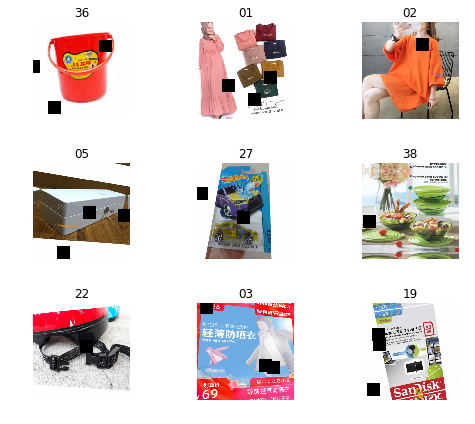

In [6]:
data.show_batch(rows=3, figsize=(7,6))

In [8]:
print(data.classes)
len(data.classes),data.c

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41']


(42, 42)

In [7]:
model = torchvision.models.inception_v3(pretrained = True, aux_logits=False)
nf = data.c # number of output classes in your data
model.fc = nn.Linear(in_features=2048, out_features=nf) # replace fc layer

In [8]:
learn = Learner(data, model, metrics = error_rate)

In [9]:
learn.model.cuda()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [38]:
learn.fit_one_cycle(30)

Exception ignored in: <function _ConnectionBase.__del__ at 0x00000284C5DCCF28>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 132, in __del__
    self._close()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid


In [39]:
learn.save('inceptionv3_cutout_e30')

In [10]:
# Get add test to data
data.add_test(Path(path+'/test/').ls())

In [46]:
learn.load

ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
03,03,03,03,03
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
39,05,10,23,15
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Test: LabelList (12192 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: EmptyLabelList
,,,,
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data

In [10]:
learn = Learner(data, model, metrics = error_rate)

In [11]:
learn.load('inceptionv3_cutout_e30')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
03,03,03,03,03
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
39,05,10,23,15
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Test: LabelList (12192 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: EmptyLabelList
,,,,
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data, model=Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn)

In [12]:
learn.model.cuda()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [13]:
preds,y = learn.get_preds(ds_type = DatasetType.Test)
y = torch.argmax(preds,dim=1)

In [15]:
y

tensor([12,  7, 40,  ..., 10, 23, 12])

In [16]:
test_file = pd.Series([str(i)[105:] for i in learn.data.test_dl.dataset.items]).rename('filename')
test_cat = pd.Series(y).rename('category')
test_df = pd.concat((test_file, test_cat), axis = 1)

In [17]:
# Load test.csv and get images included there
test_csv = pd.read_csv(path+'/test.csv')

In [22]:
test_df = test_df[test_df.filename.isin(list(test_csv.filename))].set_index('filename')

category
filename                                      
0004b03ad7eabfb3989727c461310a84.jpg        12
0004d34271d0a0253f8a95d0746bae05.jpg         7
000d4ad3d0a372fd6eea2fee6bf738ef.jpg        40
0012f125ad07123e69468ae1d1d59de4.jpg        22
0015831b249b856e569e883a9dc6d4fa.jpg        12
001640e7947935ad28d00f740c3eaefc.jpg         1
00196f6ef552b2c4d78365818acdbce2.jpg        40
001d40e7718c79ed31750d6c988a90fc.jpg        30
001eeb075533bafbfb8e4a6f9e4b8765.jpg        11
0022bd7f6b85fe98edd3291d9824ee6c.jpg        41
0024bad614d43a571397f38449f3a1bc.jpg        41
002a5961a6800f9595aa3538a5ed4098.jpg        24
002b4b3699a9c593521baff1dd5aa06e.jpg        19
003107eede72317f305efc84437dc3c8.jpg         6
003267dc67eda09beb3b3181cfd6f583.jpg         8
00375eb5f73b0b0278c56f4e42917483.jpg        40
00403ecb694e66bac869f1551b1b1dc5.jpg        36
004316305306b74ecd1c9a887954aa17.jpg        38
00461812fe82130cc2111cd9d096fb0b.jpg        29
00467308f26e8aba1366c9199650beeb.jpg        34
00477bc3546ac0a7ea7d7fd413dbbabc.jpg        11
004a5bb95294bf01bba87e3bd9042bc5.jpg         2
004d5a1242570c9c95f1fd0e612acc2f.jpg        39
004df33b3487b4691f638c5603341901.jpg        23
004ee72a492a04f1dd52cb0c71712ee3.jpg        25
0059de7d5ca23c69b2ddde7987df1ef0.jpg        30
005fdd5ba28f3dbb0bbbf60a60347c54.jpg        30
006aaf824bd76eb50a9e4ef920152733.jpg        28
0071a15993b6b85c3328c193ee4638e6.jpg        15
0071aa31a2c6a223fe662ffa54175dbc.jpg        29
...                                        ...
ff491c5242aa249d14d505f41e759558.jpg        25
ff495009d2603d6b33f103e9589f5898.jpg        22
ff4fdb316eddd2f1370c2b9aa9f423cf.jpg        28
ff54f17eb9eb17b951cdf35750bce9ee.jpg        35
ff5519d524ee9e7cb287aee7b24a4218.jpg        20
ff6333beac21828bf27660f93a8d8113.jpg        35
ff69f977165454416e4b2be0a4051435.jpg        36
ff72ea1da14db995014ded25be24f1fe.jpg        30
ff7b3cef2551951f1d43bd0cb6175beb.jpg        36
ff829e2347be9d25de239ce2a589e131.jpg         8
ff88a085b830abc14df9cb3b06a83126.jpg         4
ff8e4f36a9df90ff549e7e0f1015e07a.jpg        31
ff8ff76a4391fa7493fc16604482c26c.jpg         7
ff909593a837258672e84eac4f2851cc.jpg         7
ff93fbef3ed5e670d0d3fdf32faf8de0.jpg         1
ff96a721bb59864eb17a11bbd3d9abd1.jpg        26
ff9b7ed66590f8bb5941aede9def9e5c.jpg         1
ffa4ec4e5008b4b5c839193d89751e30.jpg         9
ffac1136c1da05b4fe8f99880ab5a41d.jpg         9
ffaf1cd5364f281ed24369015fd22f40.jpg         8
ffb0eb5796fa076fe42f3e0f81146707.jpg         1
ffb7603697bfbfe180eae69f26ce261e.jpg        15
ffd702b2f2f78dfa90152428cc7a08b7.jpg        10
ffe168f509fd94db33c80a042a31eb07.jpg        33
ffec2a45adbdce3a5c6c1716ab1ac6f4.jpg        22
ffef3b0e7505855ba5794ebab9aff719.jpg         9
ffef86f7872cd020992e00b7cf6585c7.jpg        20
fff8fdfc178e3e94414fc10c69271f88.jpg        10
fff9ee1d7f920b920dd603631d24bc07.jpg        23
fffb6700a1f0e34254d508cd5f125180.jpg        12

[12186 rows x 1 columns]

In [24]:
# Not double digit
test_df.to_csv('inceptionv3_e30_cutout_1')

In [29]:
(pd.DataFrame(test_df.category.apply(lambda x: '0'+str(x) if x < 10 else str(x)))).to_csv('inceptionv3_e30_cutout_01')

# Add more epochs to original 30

In [12]:
learn.load('inceptionv3_cutout_e30')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
03,03,03,03,03
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
39,05,10,23,15
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Test: None, model=Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track

In [13]:
learn.unfreeze()

In [14]:
learn.fit_one_cycle(30)

KeyboardInterrupt: 

In [17]:
learn.model()

TypeError: forward() missing 1 required positional argument: 'x'

# Resnet 50

In [2]:
# Define where to data bunch
path = '/Users/pbata/Documents/pbata files (personal)/Shopee Code League/C02_Product_Detection/SCL_C02_data/'
train_df = pd.read_csv(path+'train.csv').rename(columns={'category':'label'})
train_df.label = ['0' + str(x) if x <10 else str(x) for x in train_df.label]
train_df.loc[:,'name'] = train_df.apply(lambda x: 'train/'+str(x.label)+'/'+str(x.filename), axis = 1)
train_df.drop('filename', axis = 1, inplace = True)
train_df = train_df.set_index('name').reset_index()
bs = 32

In [3]:
tfms = get_transforms(xtra_tfms = cutout(n_holes=(1,3)))
data = ImageDataBunch.from_df(path, train_df, ds_tfms=tfms, size=280, bs=bs, seed = 2020, valid_pct = 0.2).normalize(imagenet_stats)
data.add_test(Path(path+'/test/').ls())

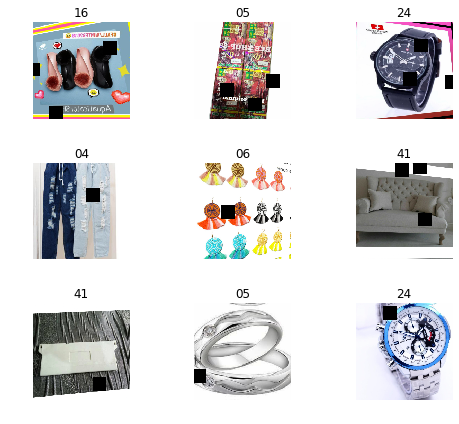

In [4]:
data.show_batch(rows=3, figsize=(7,6))

In [5]:
learn = cnn_learner(data, models.resnet50, metrics = error_rate)

In [6]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [7]:
learn.fit_one_cycle(10)
learn.save('resnet50_10e')

In [15]:
learn = cnn_learner(data, models.resnet50, metrics = error_rate)
learn.load('resnet50_10e')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
03,03,03,03,03
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
39,05,10,23,15
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Test: LabelList (12192 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: EmptyLabelList
,,,,
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1):

In [69]:
def getpreds(learn, filesave):
    preds,y = learn.get_preds(ds_type = DatasetType.Test)
    y = torch.argmax(preds,dim=1)
    test_file = pd.Series([str(i)[105:] for i in learn.data.test_dl.dataset.items]).rename('filename')
    test_cat = pd.Series(y).rename('category')
    test_df = pd.concat((test_file, test_cat), axis = 1)
    test_csv = pd.read_csv(path+'/test.csv')
    test_df = test_df[test_df.filename.isin(list(test_csv.filename))].set_index('filename')
    (pd.DataFrame(test_df.category.apply(lambda x: '0'+str(x) if x < 10 else str(x)))).to_csv(filesave)

In [16]:
getpreds(learn, 'resnet50_10e_co.csv')

---------------

## Adding epochs

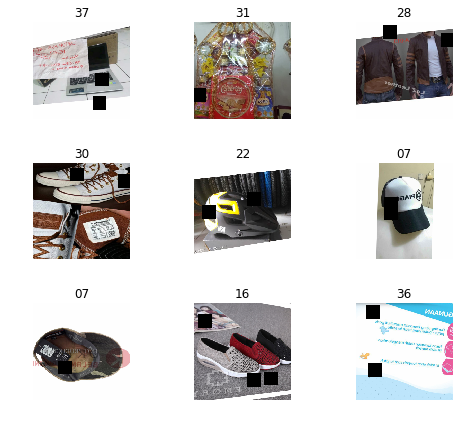

In [2]:
# Do 90 epochs while doing callback

# Define where to data bunch
path = '/Users/pbata/Documents/pbata files (personal)/Shopee Code League/C02_Product_Detection/SCL_C02_data/'
train_df = pd.read_csv(path+'train.csv').rename(columns={'category':'label'})
train_df.label = ['0' + str(x) if x <10 else str(x) for x in train_df.label]
train_df.loc[:,'name'] = train_df.apply(lambda x: 'train/'+str(x.label)+'/'+str(x.filename), axis = 1)
train_df.drop('filename', axis = 1, inplace = True)
train_df = train_df.set_index('name').reset_index()
bs = 32

# Do cutout on data and databunch
tfms = get_transforms(xtra_tfms = cutout(n_holes=(1,3)))
data = ImageDataBunch.from_df(path, train_df, ds_tfms=tfms, size=280, bs=bs, seed = 2020, valid_pct = 0.2).normalize(imagenet_stats)
data.add_test(Path(path+'/test/').ls())

# Show the data
data.show_batch(rows=3, figsize=(7,6))

In [3]:
# Define learner and active cuda
learn = cnn_learner(data, models.resnet50, metrics = error_rate)
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [4]:
learn.fit_one_cycle(90, callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate')], tot_epochs = 150, start_epoch = 0)
# learn.save('resnet50_10e')

Better model found at epoch 0 with error_rate value: 0.2951418459415436.
Better model found at epoch 1 with error_rate value: 0.2749786376953125.
Better model found at epoch 2 with error_rate value: 0.26216909289360046.
Better model found at epoch 3 with error_rate value: 0.25377169251441956.
Better model found at epoch 4 with error_rate value: 0.24826833605766296.
Better model found at epoch 5 with error_rate value: 0.24238543212413788.
Better model found at epoch 6 with error_rate value: 0.24134168028831482.
Better model found at epoch 7 with error_rate value: 0.23877976834774017.
Better model found at epoch 8 with error_rate value: 0.2364550679922104.
Better model found at epoch 9 with error_rate value: 0.23322895169258118.
Better model found at epoch 11 with error_rate value: 0.23038238286972046.
Better model found at epoch 12 with error_rate value: 0.2269665002822876.
Better model found at epoch 14 with error_rate value: 0.22554321587085724.
Better model found at epoch 15 with err

RuntimeError: CUDA error: unknown error

In [4]:
learn.load('bestmodel_35')
learn.fit_one_cycle(55, callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate')], start_epoch = 36)

Loaded bestmodel_35


Better model found at epoch 36 with error_rate value: 0.20784704387187958.
Better model found at epoch 37 with error_rate value: 0.2051427960395813.
Better model found at epoch 39 with error_rate value: 0.20500047504901886.
Better model found at epoch 40 with error_rate value: 0.20428882539272308.
Better model found at epoch 41 with error_rate value: 0.20253345370292664.
Better model found at epoch 42 with error_rate value: 0.19978176057338715.
Better model found at epoch 43 with error_rate value: 0.1987854689359665.
Better model found at epoch 44 with error_rate value: 0.19707752764225006.
Better model found at epoch 46 with error_rate value: 0.19669798016548157.
Better model found at epoch 47 with error_rate value: 0.19532214105129242.


In [5]:
learn.save('bestmodel_55')

In [6]:
learn.fit_one_cycle(90, callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate')], start_epoch = 56)

Loaded bestmodel_55


Better model found at epoch 56 with error_rate value: 0.20500047504901886.
Better model found at epoch 57 with error_rate value: 0.203956738114357.


KeyboardInterrupt: 

In [4]:
learn.load('bestmodel_54')
learn.fit_one_cycle(90, callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate')], start_epoch = 55)

Loaded bestmodel_54


Better model found at epoch 55 with error_rate value: 0.20229622721672058.
Better model found at epoch 62 with error_rate value: 0.20139482617378235.
Better model found at epoch 65 with error_rate value: 0.19869057834148407.
Better model found at epoch 70 with error_rate value: 0.19674542546272278.
Better model found at epoch 71 with error_rate value: 0.1964607685804367.
Better model found at epoch 72 with error_rate value: 0.196033775806427.
Better model found at epoch 75 with error_rate value: 0.19508492946624756.
Better model found at epoch 77 with error_rate value: 0.19418351352214813.
Better model found at epoch 80 with error_rate value: 0.19385141134262085.
Better model found at epoch 81 with error_rate value: 0.19233323633670807.
Better model found at epoch 82 with error_rate value: 0.19219091534614563.
Better model found at epoch 83 with error_rate value: 0.19195368885993958.
Better model found at epoch 85 with error_rate value: 0.19147926568984985.


In [5]:
learn.save('bestmodel_89')

In [8]:
# Try best model vs last epoch
getpreds(learn, 'resnet50_89e_co.csv')

In [9]:
learn.load('bestmodel_85')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
03,03,03,03,03
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
39,05,10,23,15
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Test: LabelList (12192 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: EmptyLabelList
,,,,
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1):

In [10]:
getpreds(learn, 'resnet50_85e_co.csv')

In [4]:
learn.fit_one_cycle(105, callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate')], start_epoch = 90)

Loaded bestmodel_89


Better model found at epoch 90 with error_rate value: 0.19271278381347656.
Better model found at epoch 92 with error_rate value: 0.1924755722284317.
Better model found at epoch 94 with error_rate value: 0.19223834574222565.
Better model found at epoch 95 with error_rate value: 0.1920011341571808.
Better model found at epoch 98 with error_rate value: 0.19157415628433228.
Better model found at epoch 99 with error_rate value: 0.19143182039260864.


In [7]:
getpreds(learn, 'resnet50_105e_co.csv')

In [8]:
learn.save('bestmodel_104')

In [ ]:
learn.fit_one_cycle(105, callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate')], start_epoch = 105)

In [9]:
learn.load('bestmodel_99')
getpreds(learn, 'resnet50_100e_co.csv')

In [4]:
learn.load('bestmodel_104')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
03,03,03,03,03
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
39,05,10,23,15
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Test: LabelList (12192 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: EmptyLabelList
,,,,
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1):

## Only cutmix

In [2]:
class CutMixCallback(LearnerCallback):
    '''Adapted from :
    paper: https://arxiv.org/abs/1905.04899
    github: https://github.com/clovaai/CutMix-PyTorch
    and mixup in the fastai library.'''

    def __init__(self, learn:Learner, alpha:float=1., stack_y:bool=True, true_λ:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_y,self.true_λ = alpha,stack_y,true_λ

    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies cutmix to `last_input` and `last_target` if `train`."
        if not train: return
        λ = np.random.beta(self.alpha, self.alpha)
        λ = max(λ, 1- λ)
        bs = last_target.size(0)
        idx = torch.randperm(bs).to(last_input.device)
        x1, y1 = last_input[idx], last_target[idx]

        #Get new input
        last_input_size = last_input.size()
        bbx1, bby1, bbx2, bby2 = rand_bbox(last_input_size, λ)
        new_input = last_input.clone()
        new_input[..., bby1:bby2, bbx1:bbx2] = x1[..., bby1:bby2, bbx1:bbx2]
        λ = last_input.new([λ])
        λ = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (last_input_size[-1] * last_input_size[-2]))
        λ = last_input.new([λ])

        # modify last target
        if self.stack_y:
            new_target = torch.cat([last_target.unsqueeze(1).float(), y1.unsqueeze(1).float(),
                                    λ.repeat(last_input_size[0]).unsqueeze(1).float()], 1)
        else:
            if len(last_target.shape) == 2:
                λ = λ.unsqueeze(1).float()
            new_target = last_target.float() * λ + y1.float() * (1-λ)

        return {'last_input': new_input, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()


def rand_bbox(last_input_size, λ):
    '''lambd is always between .5 and 1'''

    W = last_input_size[-1]
    H = last_input_size[-2]
    cut_rat = np.sqrt(1. - λ) # 0. - .707
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def cutmix(learn:Learner, alpha:float=1., stack_x:bool=False, stack_y:bool=True, true_λ:bool=True) -> Learner:
    "Add cutmix https://arxiv.org/pdf/1905.04899.pdf to `learn`."
    learn.callback_fns.append(partial(CutMixCallback, alpha=alpha, stack_y=stack_y, true_λ=true_λ))
    return learn

setattr(cutmix, 'cb_fn', CutMixCallback)
Learner.cutmix = cutmix

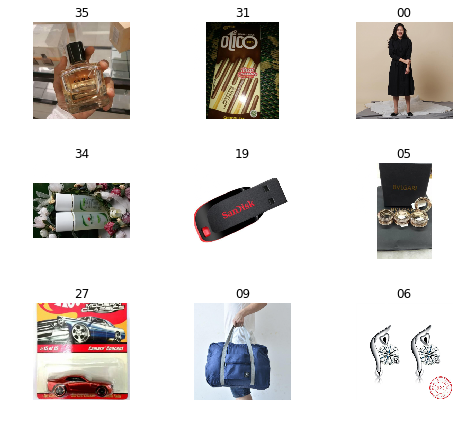

In [3]:
# Define where to data bunch
path = '/Users/pbata/Documents/pbata files (personal)/Shopee Code League/C02_Product_Detection/SCL_C02_data/'
train_df = pd.read_csv(path+'train.csv').rename(columns={'category':'label'})
train_df.label = ['0' + str(x) if x <10 else str(x) for x in train_df.label]
train_df.loc[:,'name'] = train_df.apply(lambda x: 'train/'+str(x.label)+'/'+str(x.filename), axis = 1)
train_df.drop('filename', axis = 1, inplace = True)
train_df = train_df.set_index('name').reset_index()
bs = 32

# Do cutout on data and databunch
data = ImageDataBunch.from_df(path, train_df, size=280, bs=bs, seed = 2020, valid_pct = 0.2).normalize(imagenet_stats)
data.add_test(Path(path+'/test/').ls())

# Show the data
data.show_batch(rows=3, figsize=(7,6))

In [4]:
# Define learner and active cuda
learn = cnn_learner(data, models.resnet50, metrics = error_rate).cutmix()
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [7]:
learn.fit_one_cycle(30, callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate', name = 'best_cutmix')], tot_epochs = 150, start_epoch = 0)
# learn.save('resnet50_10e')

Better model found at epoch 0 with error_rate value: 0.3082360625267029.
Better model found at epoch 1 with error_rate value: 0.2844197750091553.
Better model found at epoch 2 with error_rate value: 0.27236929535865784.
Better model found at epoch 3 with error_rate value: 0.26240628957748413.
Better model found at epoch 4 with error_rate value: 0.2566657066345215.
Better model found at epoch 6 with error_rate value: 0.24954929947853088.
Better model found at epoch 7 with error_rate value: 0.2456115335226059.
Better model found at epoch 8 with error_rate value: 0.24513711035251617.
Better model found at epoch 9 with error_rate value: 0.24229054152965546.
Better model found at epoch 10 with error_rate value: 0.24138912558555603.
Better model found at epoch 11 with error_rate value: 0.24063004553318024.
Better model found at epoch 13 with error_rate value: 0.24039283394813538.
Better model found at epoch 14 with error_rate value: 0.23617041110992432.
Better model found at epoch 15 with er

## Get probability per class

In [9]:
learn.load('best_cutmix')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
03,03,03,03,03
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
39,05,10,23,15
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Test: LabelList (12192 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: EmptyLabelList
,,,,
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1):

In [10]:
predsdf(learn, 'cutmix_resnet50.csv')

## Create anonther neural net for most categories misclassified

In [6]:
learn.load('bestmodel_104')
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

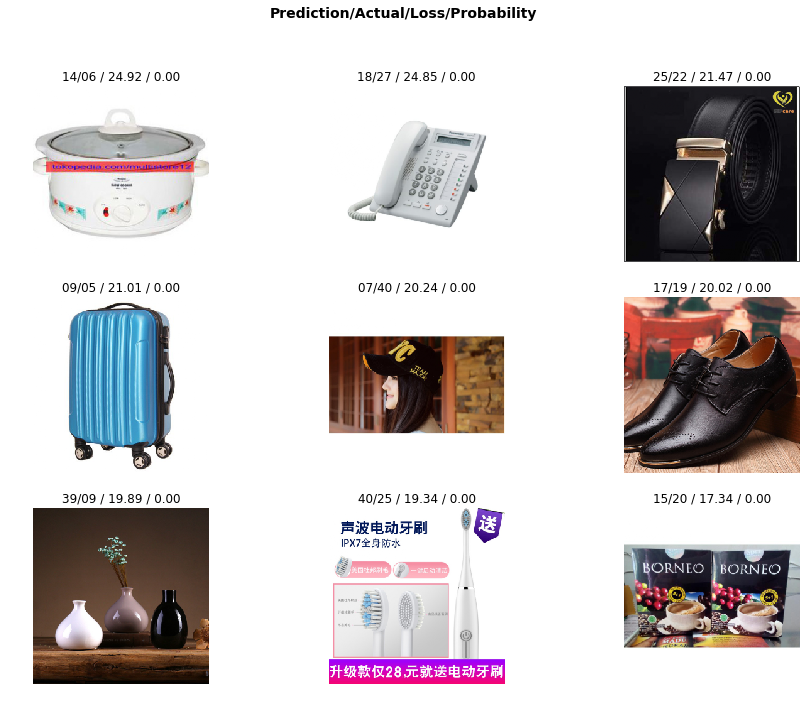

In [7]:
interp.plot_top_losses(9, figsize=(15,11))

In [8]:
doc(interp.plot_top_losses)

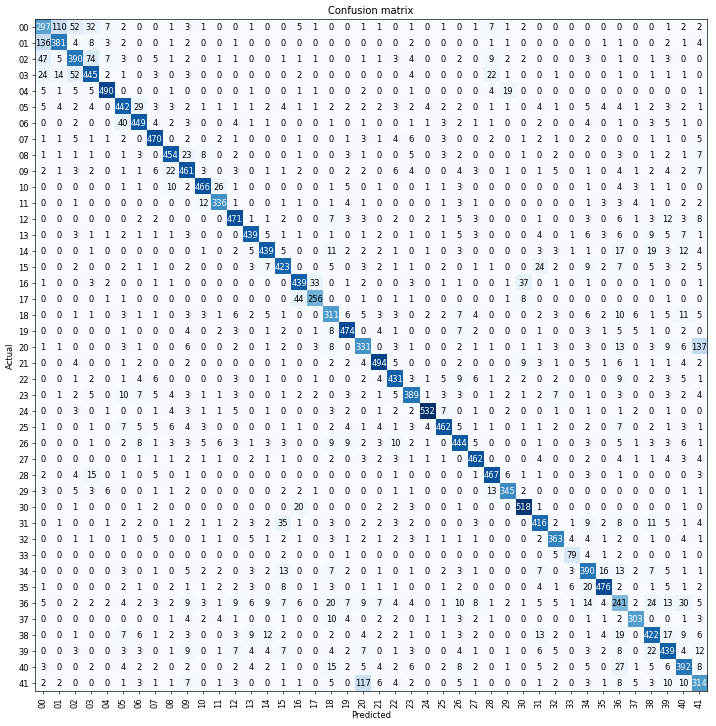

In [9]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [10]:
interp.most_confused(min_val=2)

[('20', '41', 137),
 ('01', '00', 136),
 ('41', '20', 117),
 ('00', '01', 110),
 ('02', '03', 74),
 ('00', '02', 52),
 ('03', '02', 52),
 ('02', '00', 47),
 ('17', '16', 44),
 ('06', '05', 40),
 ('16', '30', 37),
 ('31', '15', 35),
 ('16', '17', 33),
 ('00', '03', 32),
 ('36', '40', 30),
 ('05', '06', 29),
 ('40', '36', 27),
 ('10', '11', 26),
 ('03', '00', 24),
 ('15', '31', 24),
 ('36', '38', 24),
 ('08', '09', 23),
 ('03', '28', 22),
 ('09', '08', 22),
 ('39', '38', 22),
 ('30', '16', 20),
 ('35', '34', 20),
 ('36', '18', 20),
 ('04', '29', 19),
 ('14', '38', 19),
 ('38', '36', 19),
 ('14', '36', 17),
 ('38', '39', 17),
 ('34', '35', 16),
 ('28', '03', 15),
 ('40', '18', 15),
 ('03', '01', 14),
 ('36', '34', 14),
 ('20', '36', 13),
 ('29', '28', 13),
 ('34', '15', 13),
 ('34', '36', 13),
 ('36', '39', 13),
 ('38', '31', 13),
 ('11', '10', 12),
 ('12', '39', 12),
 ('14', '40', 12),
 ('38', '14', 12),
 ('39', '41', 12),
 ('14', '18', 11),
 ('18', '40', 11),
 ('31', '38', 11),
 ('10', 

In [10]:
most_confused = pd.DataFrame(interp.most_confused(min_val=2))
most_confused.columns = ['actual', 'predicted', 'wrong']

In [12]:
most_confused.head()

actual predicted  wrong
0     20        41    137
1     01        00    136
2     41        20    117
3     00        01    110
4     02        03     74

In [12]:
most_confused.loc[:,'perc'] = most_confused.wrong.cumsum()/most_confused.wrong.sum()

In [14]:
# Get top 20 pairs of mismatched categories = 31%
top = 22
list(set(most_confused[0:top].actual.to_list() + most_confused[0:top].predicted.to_list()))

['15',
 '09',
 '30',
 '40',
 '00',
 '08',
 '20',
 '06',
 '01',
 '36',
 '38',
 '11',
 '03',
 '16',
 '10',
 '05',
 '02',
 '31',
 '17',
 '41']

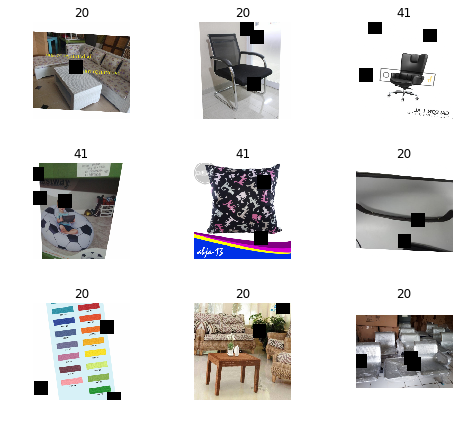

In [13]:
# Try to differentiate per pair
cats = most_confused.loc[0,['actual', 'predicted']].to_list()
train_df = pd.read_csv(path+'train.csv').rename(columns={'category':'label'})
train_df = train_df[train_df.label.isin(cats)]
train_df.loc[:,'name'] = train_df.apply(lambda x: 'train/'+str(x.label)+'/'+str(x.filename), axis = 1)
train_df.drop('filename', axis = 1, inplace = True)
train_df = train_df.set_index('name').reset_index()
bs = 32

# Get test categories as confused pair
test_renn = pd.read_csv('resnet50_105e_co.csv')

# Do cutout on data and databunch
tfms = get_transforms(xtra_tfms = cutout(n_holes=(1,3)))
data = ImageDataBunch.from_df(path, train_df, ds_tfms=tfms, size=280, bs=bs, seed = 2020, valid_pct = 0.2).normalize(imagenet_stats)
data.add_test([Path(path+'test/'+i) for i in test_renn[test_renn.category.isin(cats)].filename])

# Show the data
data.show_batch(rows=3, figsize=(7,6))

In [63]:
# Define learner and active cuda
learn = cnn_learner(data, models.resnet50, metrics = error_rate)
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [64]:
learn.fit_one_cycle(55, callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate')], start_epoch = 0)

Better model found at epoch 0 with error_rate value: 0.36030104756355286.
Better model found at epoch 1 with error_rate value: 0.3537158966064453.
Better model found at epoch 2 with error_rate value: 0.34901222586631775.
Better model found at epoch 4 with error_rate value: 0.33490121364593506.
Better model found at epoch 5 with error_rate value: 0.3320790231227875.
Better model found at epoch 6 with error_rate value: 0.32361242175102234.
Better model found at epoch 8 with error_rate value: 0.3179680109024048.
Better model found at epoch 13 with error_rate value: 0.3170272707939148.
Better model found at epoch 33 with error_rate value: 0.3160865604877472.
Better model found at epoch 35 with error_rate value: 0.31232360005378723.


In [65]:
learn.save('bestmodel_54')

In [66]:
learn.load('bestmodel_35')

Learner(data=ImageDataBunch;

Train: LabelList (4252 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
20,20,20,20,20
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Valid: LabelList (1063 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
41,20,20,41,41
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Test: LabelList (583 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: EmptyLabelList
,,,,
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): Bat

In [70]:
getpreds(learn,'resnet50_20_45.csv')

In [119]:
#Combine vanilla with sub neural net
resnet50_2045 = pd.read_csv('resnet50_20_45.csv')
resnet50_2045.category = ['20' if x == 0 else '41' for x in resnet50_2045.category]
resnet50_vanilla = pd.read_csv('resnet50_105e_co.csv')

In [124]:
# Checking
resnet_nn_check = resnet50_2045.join(resnet50_vanilla[resnet50_vanilla.filename.isin(resnet50_2045.filename)].set_index('filename').rename(columns = {'category':'vanilla'}), on = 'filename')
resnet_nn_check.vanilla = resnet_nn_check.vanilla.apply(lambda x: str(x))
resnet_nn_check[resnet_nn_check.vanilla != resnet_nn_check.category]

filename category vanilla
2    00be15de5ebf1c990320e35a0a07cf68.jpg       41      20
5    02c025eabfb20297b59a5f2f7360acba.jpg       41      20
6    02daa59d39ae9e839de47bc2359372f3.jpg       20      41
8    0387ea5b083ae8124f488b7c15c5cb0d.jpg       41      20
21   07f7c064fbf1b933022ea897f80dccca.jpg       41      20
24   092855992c0a55eb08a318d88f48c7f5.jpg       20      41
25   09a51807798d1c2c14721be5738e8db1.jpg       20      41
40   0f98611bfe1803be2e28da467ee47c5b.jpg       20      41
44   11c9981bd628010f765b14d5ca085718.jpg       41      20
45   129641f39a5cc37fa7a4e2261a91c3f4.jpg       20      41
49   133bf282cd606e8866df945ce86ef3f9.jpg       20      41
52   150f969f48565a5ec2afa3865e0e0517.jpg       20      41
58   179b57fd95963aaefc2d58603469d8cc.jpg       20      41
59   17b080529ee145ab83718e20d32dc8c7.jpg       20      41
60   180be953c3f2b476125c7244716d7d21.jpg       20      41
62   1931b178879f0188a335d6b094a26b71.jpg       20      41
66   19d80526e0758c431974daeeb2647aad.jpg       20      41
69   1a8897cb4d7a6eb75b662ea6d2ca9499.jpg       41      20
70   1b4024da305ce74941c8900fd2501032.jpg       20      41
71   1ba47fad280dcfd5dcb9604b515492e7.jpg       20      41
74   1c4c70741fe3bd3768fe426e09f281cf.jpg       20      41
79   201d381aa34dafe9927296a87086069b.jpg       41      20
80   20a07b421681b6ce424204aa641df656.jpg       20      41
87   24e6ab307657d6820ec07409d3674dc6.jpg       41      20
104  2cd2b15cfc2686dbade3449751436dda.jpg       41      20
110  2f9b50f17dc91c1cb50503b9efeb9a06.jpg       20      41
117  334766d894e8416e9d03e2f1e83f0b30.jpg       20      41
123  350057ad9d87a2ecb6df477d1c9819a7.jpg       20      41
125  36364ec61bcb20f2727d22b01f621568.jpg       20      41
126  3682da182ac7c8cc4500990986945190.jpg       20      41
..                                    ...      ...     ...
447  c64e7761eb36339b154335d9fc91f9ba.jpg       20      41
452  c7bf4a2d9f7e3c7113281c304793633e.jpg       20      41
459  ca6cfb4a938d7b8887ba17f7e3953b9e.jpg       20      41
468  ce43f23d5cb9495040881335ffe22389.jpg       41      20
472  d0704f4802773d186f937479f2444c37.jpg       41      20
473  d0994769fc5a15015970e07596aee853.jpg       20      41
474  d124f8b3058bbc7eeea5e66bd4eb17bc.jpg       20      41
484  d50ebe9a1cabb7948aaf3cbf6e183105.jpg       41      20
486  d5d5087a29b27959c23fc88dff380e52.jpg       20      41
489  d81cd8f4bf4b48520a2a17424f42c9f6.jpg       20      41
499  da2db858c9b2363a0a12caa561dbd785.jpg       41      20
505  dd4a68c1aecad1dd97f673394b9cb152.jpg       20      41
514  e309f4654454a47e5c2ec38316a5ad96.jpg       41      20
521  e55090cc31c7f4b0d5981dda3531c2ea.jpg       20      41
522  e633b60a1b5abefd7d95e52fdb5b9a61.jpg       20      41
525  e68cbdd7b67b336327c8b3969fe60554.jpg       20      41
528  e700b2277a39c35d5a81a50d2872db50.jpg       20      41
531  e8612eca5641a376132a23b3f47b11cf.jpg       41      20
533  e9c30c4b08de687bb98d36d0748c6962.jpg       20      41
537  eb6747f4a437f37f46113af49c47c57e.jpg       20      41
538  ebcd0e5d2887c7d19e904dbd06d9066a.jpg       20      41
544  ef2ca17efc968b7a954cf220fc92ab57.jpg       20      41
545  ef4057216a2a7385de9c9f4f9eea9115.jpg       20      41
550  f15071b133910a46fe3564af71441c46.jpg       20      41
555  f26a17c816425fa4ba4c608b4a3537c4.jpg       20      41
558  f41d29ae965a8d715d932e04a5878852.jpg       20      41
561  f544c7acd877bca6bab18a0a34673b73.jpg       20      41
563  f680280fe3d95142342e465a65820fe2.jpg       20      41
565  f845cf7b3e37bc6433b778577c438104.jpg       41      20
570  faf7aa95aff9d7d157b99728df65bbd3.jpg       20      41

[129 rows x 3 columns]

In [125]:
# Switching those with 20 and 41 with new nn predictions
update_2041 = resnet50_vanilla[~resnet50_vanilla.filename.isin(resnet_nn_check.filename)]
update_2041.category = ['0'+str(x) if x<10 else str(x) for x in update_2041.category]
update_2041 = pd.concat((update_2041,resnet50_2045)).set_index('filename')
update_2041.to_csv('resnet50_update_2041.csv')

In [128]:
update_2041

category
filename                                     
0004b03ad7eabfb3989727c461310a84.jpg       12
0004d34271d0a0253f8a95d0746bae05.jpg       16
000d4ad3d0a372fd6eea2fee6bf738ef.jpg       40
0012f125ad07123e69468ae1d1d59de4.jpg       22
0015831b249b856e569e883a9dc6d4fa.jpg       12
001640e7947935ad28d00f740c3eaefc.jpg       01
00196f6ef552b2c4d78365818acdbce2.jpg       40
001d40e7718c79ed31750d6c988a90fc.jpg       30
001eeb075533bafbfb8e4a6f9e4b8765.jpg       37
0022bd7f6b85fe98edd3291d9824ee6c.jpg       09
002a5961a6800f9595aa3538a5ed4098.jpg       24
002b4b3699a9c593521baff1dd5aa06e.jpg       21
003107eede72317f305efc84437dc3c8.jpg       05
003267dc67eda09beb3b3181cfd6f583.jpg       08
00375eb5f73b0b0278c56f4e42917483.jpg       40
00403ecb694e66bac869f1551b1b1dc5.jpg       37
004316305306b74ecd1c9a887954aa17.jpg       38
00461812fe82130cc2111cd9d096fb0b.jpg       29
00467308f26e8aba1366c9199650beeb.jpg       34
00477bc3546ac0a7ea7d7fd413dbbabc.jpg       11
004a5bb95294bf01bba87e3bd9042bc5.jpg       00
004d5a1242570c9c95f1fd0e612acc2f.jpg       09
004df33b3487b4691f638c5603341901.jpg       23
004ee72a492a04f1dd52cb0c71712ee3.jpg       25
0059de7d5ca23c69b2ddde7987df1ef0.jpg       30
005fdd5ba28f3dbb0bbbf60a60347c54.jpg       30
006aaf824bd76eb50a9e4ef920152733.jpg       28
0071a15993b6b85c3328c193ee4638e6.jpg       15
0071aa31a2c6a223fe662ffa54175dbc.jpg       29
007ef400782e585ef5473a6cdae32a9e.jpg       25
...                                       ...
f239056b21413bba8635a26e33588f9c.jpg       41
f24978a20e8e2251d310ca10f511d506.jpg       41
f26a17c816425fa4ba4c608b4a3537c4.jpg       20
f3a346711888de1ed0b9fff43ae55688.jpg       41
f40aec74d11bc1d05f511e15e373567f.jpg       20
f41d29ae965a8d715d932e04a5878852.jpg       20
f4392eeaea10b35adafadca70c7997c2.jpg       41
f5325c902a0dcb083b9e14d0a6be08ad.jpg       20
f544c7acd877bca6bab18a0a34673b73.jpg       20
f5a9c689f2485739fc85826f182e6d9b.jpg       20
f680280fe3d95142342e465a65820fe2.jpg       20
f6bd91700cc66b63acef1cff015a93e5.jpg       41
f845cf7b3e37bc6433b778577c438104.jpg       41
f95d477b242a327927d9ff5f8a72a9da.jpg       20
f9a15bf8bf03181200588e3ef6705b6c.jpg       20
f9a9045ebca22f4a3f3ff4d720085397.jpg       41
faf43bd6ac370e8fbf6691e8a0986bb9.jpg       41
faf7aa95aff9d7d157b99728df65bbd3.jpg       20
fb1c39d88ea4c2c1cfc45a055f28c667.jpg       41
fb5c7ce601784b9e8fa5050a3dd8cb44.jpg       41
fb78bafe4625637b4ddfff57d459178b.jpg       20
fba37bbc2a75c33c40829d7b6beeb12b.jpg       20
fbd2162c9291f98835924bdb422c933e.jpg       41
fd6195012b26ddebf8e86c9264dfe40a.jpg       20
fd663cf2b6e1d7b02938c6aaae0a32d2.jpg       20
fda622a58e2ea059f347785de07c70ea.jpg       41
fe802e16a22b123a47ea7eae5f4c3c40.jpg       20
fe86299313caa5553e740e1efd8cf7ec.jpg       20
ff11cf8409d83e65b0a84056c6fb8f4b.jpg       20
ffef86f7872cd020992e00b7cf6585c7.jpg       20

[12186 rows x 1 columns]

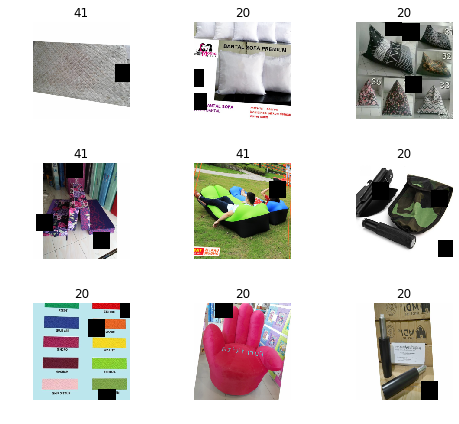

In [11]:
# Train nn using resnet152 on 20-41 pair

# Try to differentiate per pair
cats = most_confused.loc[0,['actual', 'predicted']].to_list()
train_df = pd.read_csv(path+'train.csv').rename(columns={'category':'label'})
train_df = train_df[train_df.label.isin(cats)]
train_df.loc[:,'name'] = train_df.apply(lambda x: 'train/'+str(x.label)+'/'+str(x.filename), axis = 1)
train_df.drop('filename', axis = 1, inplace = True)
train_df = train_df.set_index('name').reset_index()
bs = 16

# Get test categories as confused pair
test_renn = pd.read_csv('resnet50_105e_co.csv')

# Do cutout on data and databunch
tfms = get_transforms(xtra_tfms = cutout(n_holes=(1,3)))
data = ImageDataBunch.from_df(path, train_df, ds_tfms=tfms, size=224, bs=bs, seed = 2020, valid_pct = 0.2).normalize(imagenet_stats)
data.add_test([Path(path+'test/'+i) for i in test_renn[test_renn.category.isin(cats)].filename])

# Show the data
data.show_batch(rows=3, figsize=(7,6))

In [12]:
# Define learner and active cuda
learn = cnn_learner(data, models.resnet152, metrics = error_rate)
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [13]:
print(data.classes)
len(data.classes),data.c

[20, 41]


(2, 2)

In [14]:
learn.fit_one_cycle(90, callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate')], start_epoch = 0)

Better model found at epoch 0 with error_rate value: 0.37253057956695557.
Better model found at epoch 1 with error_rate value: 0.3537158966064453.
Better model found at epoch 3 with error_rate value: 0.34901222586631775.
Better model found at epoch 7 with error_rate value: 0.33772343397140503.
Better model found at epoch 8 with error_rate value: 0.33584195375442505.
Better model found at epoch 11 with error_rate value: 0.32361242175102234.
Better model found at epoch 12 with error_rate value: 0.32267168164253235.
Better model found at epoch 17 with error_rate value: 0.32173094153404236.
Better model found at epoch 20 with error_rate value: 0.3142050802707672.
Better model found at epoch 25 with error_rate value: 0.30950140953063965.


KeyboardInterrupt: 

In [75]:
preds,y = learn.get_preds(ds_type = DatasetType.Test)
y = torch.argmax(preds,dim=1)
test_file = pd.Series([str(i)[105:] for i in learn.data.test_dl.dataset.items]).rename('filename')
test_cat = pd.Series(y).rename('category')
test_df = pd.concat((test_file, test_cat), axis = 1)
test_csv = pd.read_csv(path+'/test.csv')
test_df = test_df[test_df.filename.isin(list(test_csv.filename))].set_index('filename')
# (pd.DataFrame(test_df.category.apply(lambda x: '0'+str(x) if x < 10 else str(x)))).to_csv(filesave)

In [11]:
learn.load('inceptionv3_cutout_e30')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
03,03,03,03,03
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
39,05,10,23,15
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Test: LabelList (12192 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: EmptyLabelList
,,,,
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data, model=Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn)

In [14]:
predsdf(learn, 'inceptionv3_cutout_e30_preds.csv')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


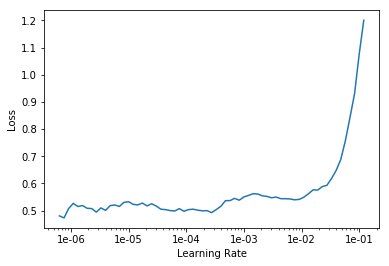

In [15]:
# Try improving lr
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace=True)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 6

In [17]:
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-2))

KeyboardInterrupt: 

# Using EfficientNet

## On top pair

In [4]:
learn.load('bestmodel_104')
# interp = ClassificationInterpretation.from_learner(learn)
# losses,idxs = interp.top_losses()
# len(data.valid_ds)==len(losses)==len(idxs)

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
03,03,03,03,03
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
39,05,10,23,15
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Test: LabelList (12192 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: EmptyLabelList
,,,,
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1):

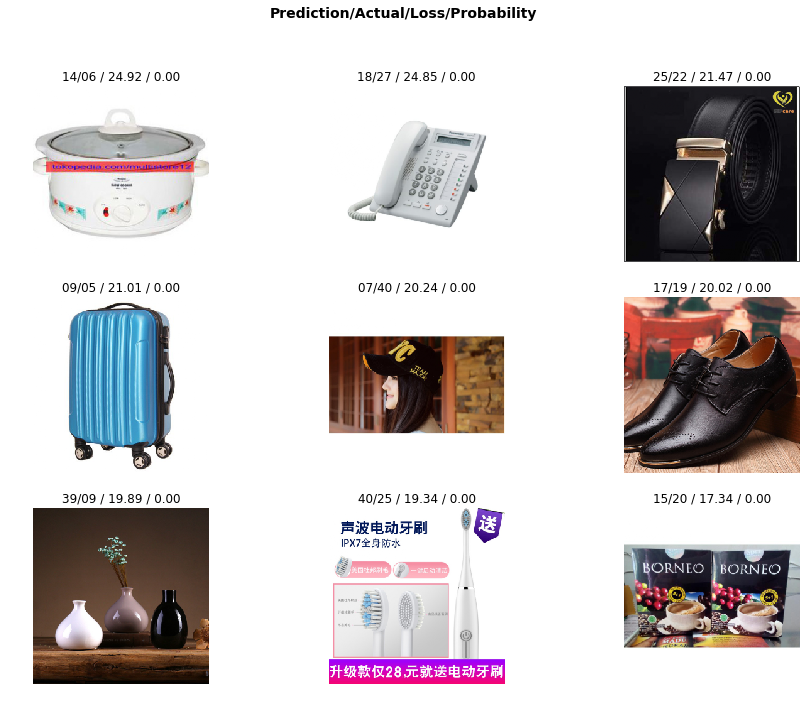

In [5]:
interp.plot_top_losses(9, figsize=(15,11))

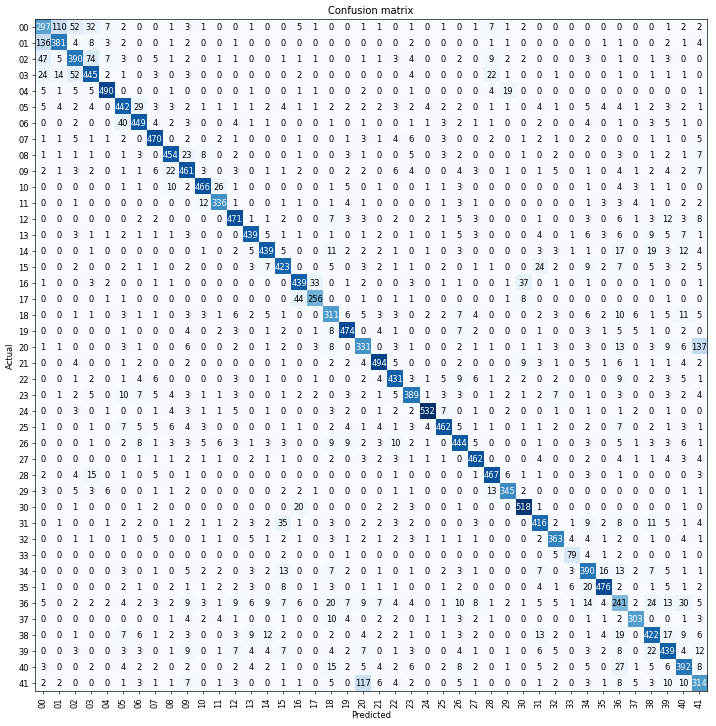

In [6]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [7]:
most_confused = pd.DataFrame(interp.most_confused(min_val=2))
most_confused.columns = ['actual', 'predicted', 'wrong']

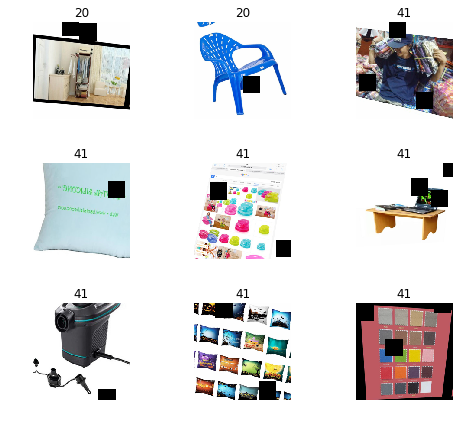

In [5]:
# Try to differentiate per pair
# cats = most_confused.loc[0,['actual', 'predicted']].to_list()
cats = ['20','41']
train_df = pd.read_csv(path+'train.csv').rename(columns={'category':'label'})
train_df = train_df[train_df.label.isin(cats)]
train_df.loc[:,'name'] = train_df.apply(lambda x: 'train/'+str(x.label)+'/'+str(x.filename), axis = 1)
train_df.drop('filename', axis = 1, inplace = True)
train_df = train_df.set_index('name').reset_index()
bs = 16

# Get test categories as confused pair
test_renn = pd.read_csv('resnet50_105e_co.csv')

# Do cutout on data and databunch
tfms = get_transforms(xtra_tfms = cutout(n_holes=(1,3)))
data = ImageDataBunch.from_df(path, train_df, ds_tfms=tfms, size=224, bs=bs, seed = 2020, valid_pct = 0.2).normalize(imagenet_stats)
data.add_test([Path(path+'test/'+i) for i in test_renn[test_renn.category.isin(cats)].filename])

# Show the data
data.show_batch(rows=3, figsize=(7,6))

In [6]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b4')
nf = data.c # number of output classes in your data
model.fc = nn.Linear(in_features=2048, out_features=nf) # replace fc layer

Loaded pretrained weights for efficientnet-b4


In [7]:
learn = Learner(data, model, metrics = error_rate)
learn.model.cuda()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [8]:
learn.fit_one_cycle(50, callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate')], start_epoch = 0)

Better model found at epoch 0 with error_rate value: 0.32549387216567993.
Better model found at epoch 1 with error_rate value: 0.32361242175102234.


KeyboardInterrupt: 

In [9]:
learn.save('efficientnetb4-2041-19')

## On whole dataset

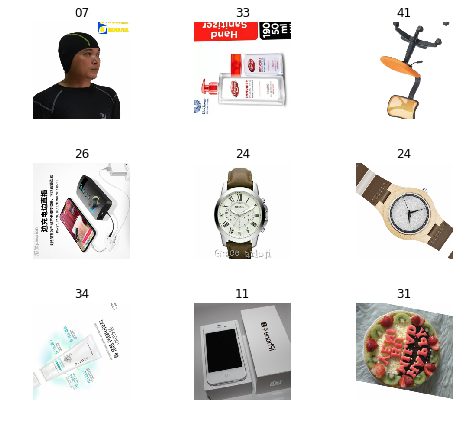

In [2]:
# Define where to data bunch
path = '/Users/pbata/Documents/pbata files (personal)/Shopee Code League/C02_Product_Detection/SCL_C02_data/'
train_df = pd.read_csv(path+'train.csv').rename(columns={'category':'label'})
train_df.label = ['0' + str(x) if x <10 else str(x) for x in train_df.label]
train_df.loc[:,'name'] = train_df.apply(lambda x: 'train/'+str(x.label)+'/'+str(x.filename), axis = 1)
train_df.drop('filename', axis = 1, inplace = True)
train_df = train_df.set_index('name').reset_index()
# bs = 16

# Do cutout on data and databunch
tfms = get_transforms(xtra_tfms = cutout(n_holes=(1,3)))
aptos19_stats = ([0.42, 0.22, 0.075], [0.27, 0.15, 0.081])
# tfms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
# data = ImageDataBunch.from_df(path, train_df, ds_tfms=tfms, size=224, bs=bs, seed = 2020, valid_pct = 0.2).normalize(imagenet_stats)
data = ImageDataBunch.from_df(df=train_df,
                              path=path,
                              valid_pct=0.1,
                              ds_tfms=get_transforms(flip_vert=True, max_warp=0.1, max_zoom=1.15, max_rotate=45.),
                              size=224,
                              bs=16, 
                              num_workers=os.cpu_count()
                             ).normalize(aptos19_stats)

data.add_test(Path(path+'/test/').ls())

# Show the data
data.show_batch(rows=3, figsize=(7,6))

In [3]:
# check classes
print(f'Classes: {data.classes}')

Classes: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41']


In [5]:
# package_path = '../input/efficientnet-pytorch/efficientnet-pytorch/EfficientNet-PyTorch-master'
# sys.path.append(package_path)
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b4')
nf = data.c # number of output classes in your data
model.fc = nn.Linear(in_features=2048, out_features=nf) # replace fc layer

Loaded pretrained weights for efficientnet-b4


In [6]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=3., reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = ((1 - pt)**self.gamma) * CE_loss
        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()

In [7]:
# build model (using EfficientNet)
learn = Learner(data, model,
                loss_func=FocalLoss(),
                metrics=[accuracy,error_rate, KappaScore(weights="quadratic")],
                callback_fns=[BnFreeze,
#                               OverSamplingCallback,
#                               partial(GradientClipping, clip=0.2),
                              partial(SaveModelCallback, monitor='kappa_score', name='best_kappa')]
               )
learn.model.cuda()
learn.split( lambda m: (model._conv_head,) )
learn.freeze()
learn.model_dir = '/tmp/'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 1.20E-02


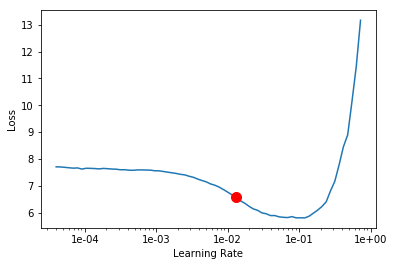

In [6]:
# train head first
learn.freeze()
learn.lr_find(start_lr=1e-5, end_lr=1e1, wd=5e-3)
learn.recorder.plot(suggestion=True)

Better model found at epoch 0 with kappa_score value: 0.752790093421936.


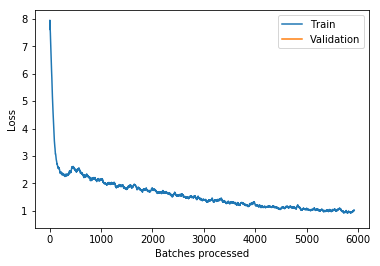

In [7]:
learn.fit_one_cycle(1, max_lr=1.5e-2, pct_start=0.1, div_factor=10, final_div=30, wd=5e-3, moms=(0.9, 0.8))
learn.save('stage-1')
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-05
Min loss divided by 10: 8.32E-05


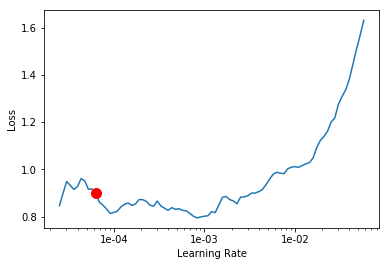

In [8]:
# unfreeze and search appropriate learning rate for full training
learn.unfreeze()
learn.lr_find(start_lr=slice(1e-6, 1e-5), end_lr=slice(1e-2, 1e-1), wd=1e-3)
learn.recorder.plot(suggestion=True)

Better model found at epoch 0 with kappa_score value: 0.7556211352348328.
Better model found at epoch 1 with kappa_score value: 0.7968552708625793.
Better model found at epoch 2 with kappa_score value: 0.8085045218467712.


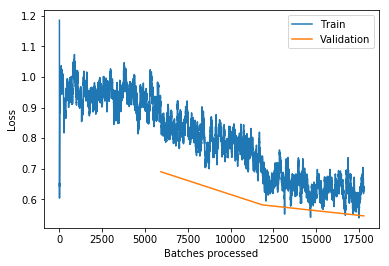

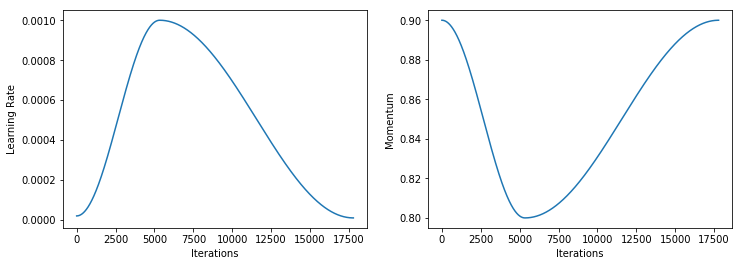

In [9]:
# train all layers
learn.fit_one_cycle(3, max_lr=slice(1e-4, 1e-3), div_factor=50, final_div=100, wd=1e-3, moms=(0.9, 0.8))
learn.save('stage-2')
learn.recorder.plot_losses()
# schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)

Better model found at epoch 0 with kappa_score value: 0.7921796441078186.
Better model found at epoch 1 with kappa_score value: 0.8065789937973022.
Better model found at epoch 2 with kappa_score value: 0.8170773983001709.
Better model found at epoch 3 with kappa_score value: 0.8192899823188782.
Better model found at epoch 5 with kappa_score value: 0.8253146409988403.
Better model found at epoch 6 with kappa_score value: 0.8259310126304626.
Better model found at epoch 7 with kappa_score value: 0.8262786865234375.


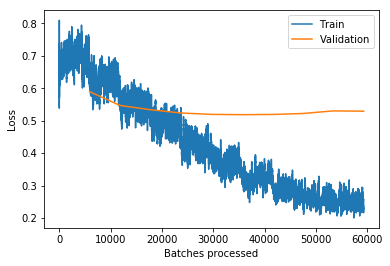

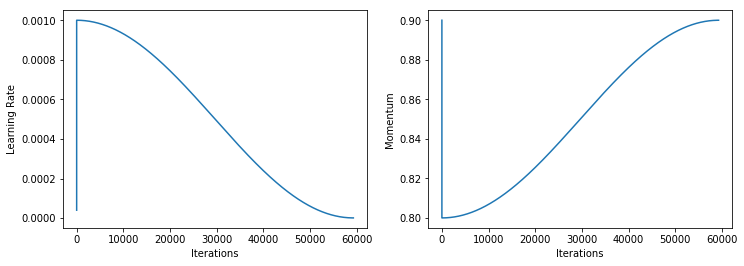

In [10]:
# train all layers
learn.fit_one_cycle(cyc_len=10, max_lr=slice(1e-4, 1e-3), pct_start=0, final_div=1000, wd=1e-3, moms=(0.9, 0.8)) # warm restart: pct_start=0
learn.save('stage-3')
learn.recorder.plot_losses()
# # schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)

Better model found at epoch 0 with kappa_score value: 0.8342515826225281.
Better model found at epoch 2 with kappa_score value: 0.8380177617073059.
Better model found at epoch 5 with kappa_score value: 0.8395971655845642.
Better model found at epoch 13 with kappa_score value: 0.8411100506782532.


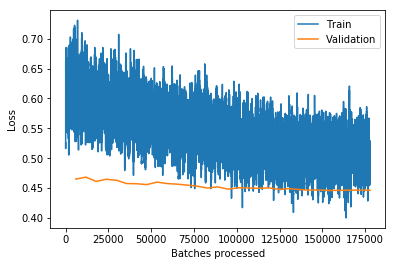

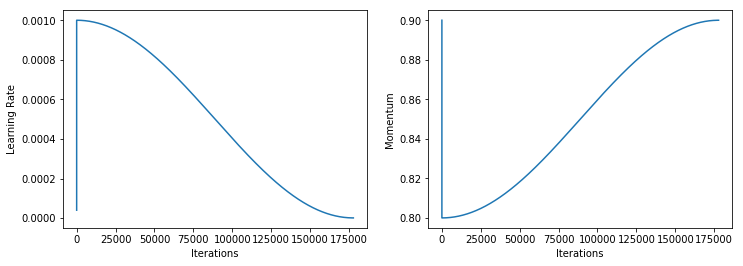

In [8]:
# train all layers
learn.load('stage-2')
learn.fit_one_cycle(cyc_len=30, max_lr=slice(1e-4, 1e-3), pct_start=0, final_div=1000, wd=1e-3, moms=(0.9, 0.8)) # warm restart: pct_start=0
learn.save('stage-4')
learn.recorder.plot_losses()
# # schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)

In [11]:
# remove zoom from FastAI TTA
learn.load('best_kappa')
tta_params = {'beta':0.12, 'scale':1.0}
preds,y = learn.TTA(ds_type=DatasetType.Test, **tta_params)

In [12]:
test_file = pd.Series([str(i)[105:] for i in learn.data.test_dl.dataset.items]).rename('filename')
test_cat = pd.Series(preds.argmax(1)).rename('category')
test_df = pd.concat((test_file, test_cat), axis = 1)
test_csv = pd.read_csv(path+'/test.csv')
test_df = test_df[test_df.filename.isin(list(test_csv.filename))].set_index('filename')
(pd.DataFrame(test_df.category.apply(lambda x: '0'+str(x) if x < 10 else str(x)))).to_csv('efficientnetb4-e30.csv')

In [21]:
# Compare e30 and e10
comp_eff = pd.concat((pd.read_csv('efficientnetb4-e30.csv').set_index('filename').rename(columns={'category': 'e10'}),
           pd.read_csv('efficientnetb4-e10.csv').set_index('filename').rename(columns={'category': 'e30'})), axis = 1)
comp_eff[comp_eff.e10 != comp_eff.e30]

e10  e30
filename                                      
0004d34271d0a0253f8a95d0746bae05.jpg   16    7
001d40e7718c79ed31750d6c988a90fc.jpg   17   29
001eeb075533bafbfb8e4a6f9e4b8765.jpg   37   40
0024bad614d43a571397f38449f3a1bc.jpg   41   20
003107eede72317f305efc84437dc3c8.jpg    5    6
00375eb5f73b0b0278c56f4e42917483.jpg   36   40
00f4a6f25a1402aa8951f029fcdd789d.jpg   28    3
011ff23fa72588eb98e3890344f8d678.jpg    0    1
01791700b135655b8d732e88a138f7e9.jpg   32   23
019e8ff4a70726ec187662bdd72fb67c.jpg    5    6
01ecb69035b948dbb3bcb57a470483a9.jpg    1    0
01edca72a95192c7ffc5e831c9e9cb57.jpg   26   20
02395ca8f389dffa53b9a5c0d23af85d.jpg    5   35
0279e5758fbd9b2fc3f82f2b0dce19d5.jpg   29   23
02cee1b30019dadd189b165231c1640d.jpg   21   16
02e056450a978d96b03bd2200a00f190.jpg   33   34
02e217342fb3c3ab09cc89e2022fb13f.jpg    4    2
0311cbb0cac10378a2aadc55ee7d8fee.jpg   19   10
035ac9c8bfa87c7736133448da4f53cb.jpg   33   36
035d709a860a68eb4908a256f9920ccf.jpg   17   16
0387ea5b083ae8124f488b7c15c5cb0d.jpg   41   20
0387f1798540e5c6bb1d2b0cbf0ba3b9.jpg    2    3
04316ddd9e5867e894028bda232b6584.jpg   26   18
044f27b9475e4fcf309e27f00392aac3.jpg   19   18
0459b9ac85466763956dceba41a8505f.jpg    9   38
045a64b124623dbe0f9da140ba502203.jpg   18   20
046ee7c7dcf5e45fb44489af3aeb092c.jpg   15   31
049328b62ba08d3787b49244c404dda8.jpg   23   32
04995a9fdcacc5cdf2a49e665bfe5090.jpg    2    3
0499c1657cb2d93dc72d6ccede03d89a.jpg   37   41
...                                   ...  ...
fc042ae8de0e3e4749d7ef0578cae56c.jpg   35   39
fc1c5b59905930eb8a13a72249040cc2.jpg    0    2
fc266c7ace636eb9b54e8aa601d71a95.jpg   34   35
fc3018fc56204c9bb3dfecba903e4bcb.jpg   18   11
fc7096dc3c81c3d9147c30415276621a.jpg    2    3
fc778db24afa0b2fdbed0de7b24f9787.jpg   15   29
fc8044dcacdc6a0c9f199658227394af.jpg    0    2
fc894fa535e16cd68b5d373dcacaec46.jpg   13   19
fca3a5beef7d65fea46c842f9ba1deab.jpg   25   19
fceb46e3c45dfb95b3952c6ee2649541.jpg   31   15
fd6195012b26ddebf8e86c9264dfe40a.jpg   18   20
fd7c17013444cb3c5aeb074b6e3f5476.jpg   10   11
fd85b6349c1021f1d3c5d2744de5b25a.jpg    0    3
fd87be39cb3209434a9ac8484e19031f.jpg   36   20
fda3b89e584c7eacb1fd251349bcafdd.jpg   40   18
fdcd2271b3c8ff5f357b08380f7a0ec9.jpg    0   26
fdd81b151b2ef648ae47ab0c81564327.jpg    2    3
fe2c7935beb30af11f351d7ee4a3711c.jpg    5   39
fe4b4254d7a2d3e304b7c438d2f4e49d.jpg   37   36
fe8ecb063d04c8b24414a36cec7b115b.jpg   26   19
fecebef3c8307761cf43e8addd70d1cc.jpg   36   13
fed6859c615375c5f63bb2c806daa817.jpg    6    2
ff061d99978da0dac83b5874fdf1daef.jpg    1    0
ff103a82301e5811d9ee044fee9dd0e8.jpg   34   31
ff2db598e1fdb13dd2442349466303db.jpg   35   34
ff317115cdc9ce1a9720ea2d413636b7.jpg   21   30
ff3c51580e77907aab257e813deb3aec.jpg   25   22
ff4637b58e8d9131563ebaedd8a61158.jpg   21   30
ff69f977165454416e4b2be0a4051435.jpg   38   40
ff8e4f36a9df90ff549e7e0f1015e07a.jpg   36   31

[1715 rows x 2 columns]

In [13]:
test_df.category.max()

41

In [43]:
test_pd = pd.DataFrame(np.array(preds)).iloc[:,0:42]
test_pd.columns = ['0'+str(x) if x < 10 else str(x) for x in range(0,42)]
test_pd.loc[:, 'filename'] = [str(i)[105:] for i in learn.data.test_dl.dataset.items]
test_csv = pd.read_csv(path+'/test.csv')
test_pd = test_pd[test_pd.filename.isin(list(test_csv.filename))].set_index('filename')
test_pd.to_csv('probs_efficientnetb4.csv')

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\queues.py", line 232, in _feed
    close()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 917, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\queues.py", line 263, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times



In [45]:
# Stage 4 of efficientnetb4
learn.fit_one_cycle(6, max_lr=1e-3, div_factor=100, wd=1e-2)
learn.save('stage-4')

Better model found at epoch 0 with kappa_score value: 0.6986691951751709.


KeyboardInterrupt: 

In [4]:
# learn = Learner(data, model, metrics = error_rate)
# learn.model.cuda()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [5]:
learn.fit_one_cycle(20, callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate')], start_epoch = 0)

Better model found at epoch 0 with error_rate value: 0.28119367361068726.


KeyboardInterrupt: 

In [6]:
learn.save('efficientnetb4-5')

------------

In [57]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)

Using cache found in C:\Users\pbata/.cache\torch\hub\pytorch_vision_v0.6.0


In [58]:
model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [66]:
filename = path+train_df.name[0]
filename

'/Users/pbata/Documents/pbata files (personal)/Shopee Code League/C02_Product_Detection/SCL_C02_data/train/03/45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg'

In [68]:
input_image = PIL.Image.open(filename)
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(299),
    torchvision.transforms.CenterCrop(299),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
print(torch.nn.functional.softmax(output[0], dim=0))

tensor([-5.5721e-01, -9.9882e-01, -4.6400e-01, -7.0386e-01, -1.6162e+00,
         2.9366e-01, -5.1741e-01, -9.7008e-01, -7.3049e-01, -9.5568e-01,
        -1.5885e-02, -5.9087e-01, -6.8864e-01,  1.6938e+00, -2.8653e-04,
        -1.4693e-01, -2.1963e-01, -1.1742e+00,  1.2751e-01,  2.1982e-01,
        -7.6830e-01,  3.8674e-01, -2.7070e-01, -8.9367e-01, -6.7289e-01,
        -3.8077e-01, -1.6934e-01, -1.4923e-01, -3.4295e-01, -2.4323e-01,
        -5.9041e-01, -1.1131e+00, -8.8613e-02, -6.1882e-01, -2.7086e-01,
         1.6620e-01,  3.6553e-01,  2.1218e-02, -3.3360e-01,  5.4636e-01,
        -2.4145e-01,  6.8942e-02, -3.9393e-01,  1.1777e+00,  5.9932e-01,
        -3.6611e-01, -1.1084e+00, -3.6283e-01,  9.2526e-01,  5.1467e-01,
         4.0468e-01, -3.8672e-01,  7.6035e-01,  1.0582e-01, -2.0331e-01,
         8.6068e-03, -4.9783e-01,  1.3792e+00, -1.4953e+00,  1.8440e-01,
        -6.8619e-01, -3.9164e-01, -4.4363e-01, -2.1402e-01,  5.0643e-01,
        -1.1271e+00,  8.1908e-01, -1.4225e+00, -7.8

In [5]:
print(torch.__version__)

1.5.1


## Load the data

In [ ]:
data_dir = 'C:\Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data'
{x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/input/pytorch_challenge-master/flower_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def inceptionv3_model_fn(features, labels, mode):
    # Load Inception-v3 model.
    module = hub.Module("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1")
    input_layer = adjust_image(features["x"])
    outputs = module(input_layer)

    logits = tf.layers.dense(inputs=outputs, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)